In [1]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load your dataset and split it into training and validation sets
data_dir = 'D:/exam/TrashNet/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 5)
valid_ds = valid_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of validation batches: 13
Number of test batches: 3


In [3]:
# Use data augmentation to add more data for training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
# Choose a pre-trained model to use as the basis for transfer learning
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to prevent them from being updated during training
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# The final layer should have as many units as there are classes
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
# Compile the model with a loss function and an optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

base_model.summary()
initial_epochs = 20
callbacks_list = [
    ModelCheckpoint(filepath='model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max'),
    CSVLogger('modeltraining.log', separator=',', append=False),
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
]

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 1.2498 - accuracy: 0.5569
Epoch 1: val_accuracy improved from -inf to 0.70905, saving model to model.hdf5


c:\Users\brain\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 192s 3s/step - loss: 1.2498 - accuracy: 0.5569 - val_loss: 0.8287 - val_accuracy: 0.7090
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.7230
Epoch 2: val_accuracy improved from 0.70905 to 0.77506, saving model to model.hdf5
64/64 [==============================] - 179s 3s/step - loss: 0.7657 - accuracy: 0.7230 - val_loss: 0.6192 - val_accuracy: 0.7751
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7616
Epoch 3: val_accuracy improved from 0.77506 to 0.77751, saving model to model.hdf5
64/64 [==============================] - 177s 3s/step - loss: 0.6879 - accuracy: 0.7616 - val_loss: 0.6544 - val_accuracy: 0.7775
Epoch 4/20
64/64 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7957
Epoch 4: val_accuracy improved from 0.77751 to 0.79218, saving model to model.hdf5
64/64 [==============================] - 177s 3s/step - loss: 0.5793 - accuracy

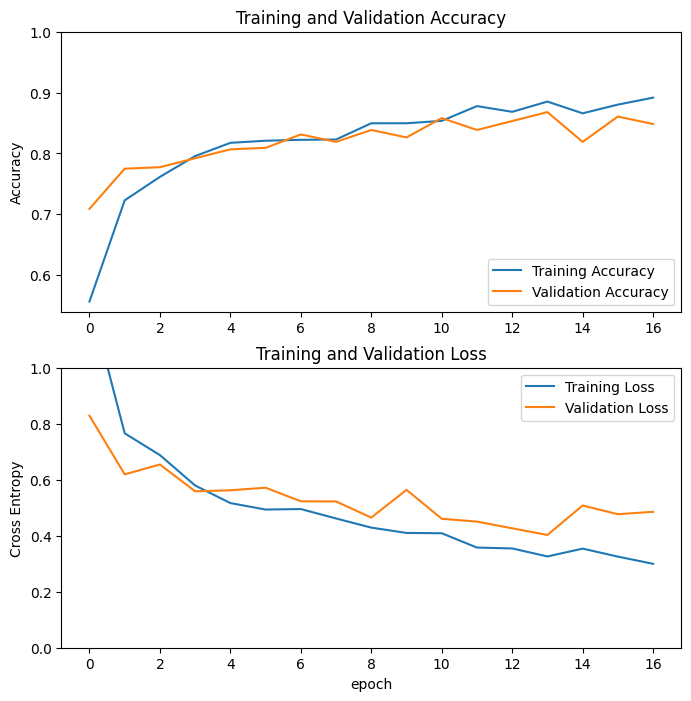

In [4]:
# Train the model on the training set
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds,
                    callbacks=callbacks_list)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [5]:
# Fine-tune from this layer onwards
fine_tune_at = 11

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Unfreeze the base model layers and re-compile the model
base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs
# Fine-tune the model on the training set
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds,
                         callbacks=callbacks_list)
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                             

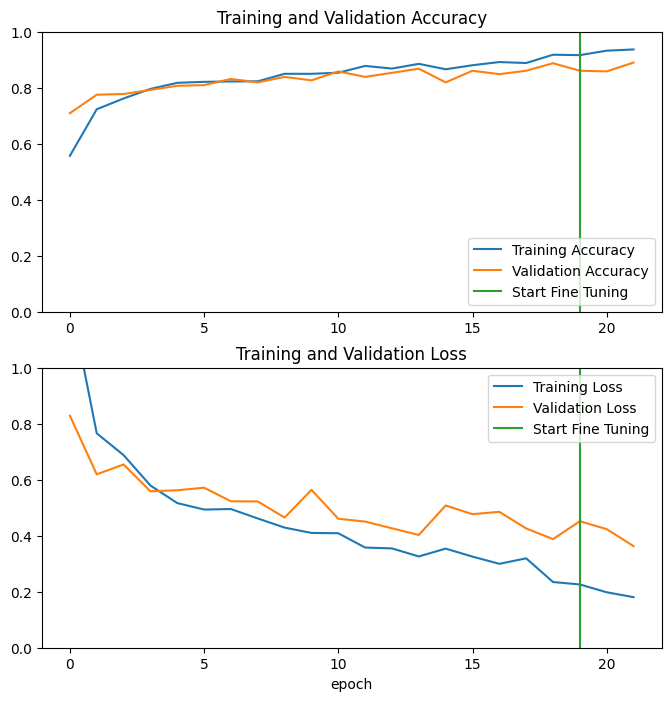

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
# Calculate precision, recall, f1-score for the training set
y_true_train = []
y_pred_train = []

for images, labels in train_ds:
    preds = model.predict(images)
    y_true_train.extend(labels.numpy())
    y_pred_train.extend(np.argmax(preds, axis=1))

print('Training Accuracy:', accuracy_score(y_true_train, y_pred_train))
print('Training Precision:', precision_score(y_true_train, y_pred_train, average='weighted'))
print('Training Recall:', recall_score(y_true_train, y_pred_train, average='weighted'))
print('Training F1 Score:', f1_score(y_true_train, y_pred_train, average='weighted'))

# Evaluate the model on the test set
y_true_test = []
y_pred_test = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true_test.extend(labels.numpy())
    y_pred_test.extend(np.argmax(preds, axis=1))

test_loss, test_acc = model.evaluate(test_ds)
print('Test loss: {}, Test accuracy: {}'.format(test_loss, test_acc))
print('Test Precision:', precision_score(y_true_test, y_pred_test, average='weighted'))
print('Test Recall:', recall_score(y_true_test, y_pred_test, average='weighted'))
print('Test F1 Score:', f1_score(y_true_test, y_pred_test, average='weighted'))

1/1 [==============================] - 1s 781ms/step
Training Accuracy: 0.9797230464886251
Training Precision: 0.9803031975677744
Training Recall: 0.9797230464886251
Training F1 Score: 0.9797954507309559
3/3 [==============================] - 7s 2s/step - loss: 0.3340 - accuracy: 0.9062
Test loss: 0.33401474356651306, Test accuracy: 0.90625
Test Precision: 0.9089379264132553
Test Recall: 0.90625
Test F1 Score: 0.9057934606183133


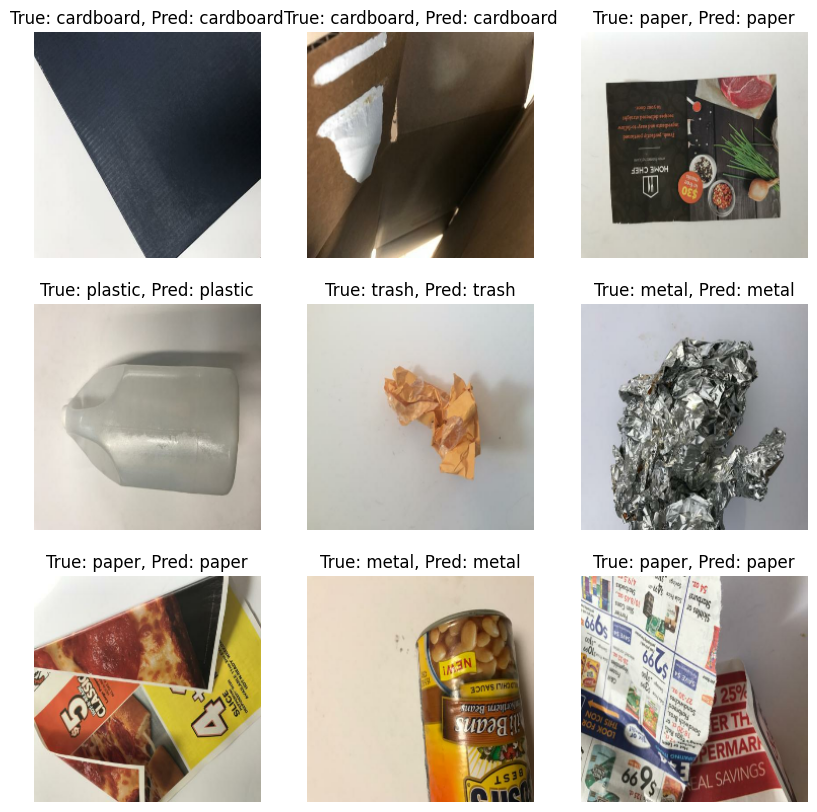

In [7]:
# Visualize predictions
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"True: {class_names[label_batch[i]]}, Pred: {class_names[np.argmax(predictions[i])]}")
    plt.axis("off")
plt.show()